In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [5]:
def plot_set_difference(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    scores={}
    for dname1 in dnames:
        scores[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_filtered',dname2,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            scores[dname1]+=list(score_1minus2.values)
    scores_df=pd.DataFrame(columns=['Data','Delta'])
    for dname in scores:
        temp=pd.DataFrame(columns=scores_df.columns)
        temp['Delta']=scores[dname]
        temp['Data']=dname
        scores_df=pd.concat([scores_df,temp])
    scores_df['Random']='Actual gene set'
    scores_random={}
    for dname1 in dnames:
        scores_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname1,'_random_uniform_0',dname2,'_random_uniform_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            scores_random[dname1]+=list(score_1minus2.values)
    scores_random_df=pd.DataFrame(columns=['Data','Delta'])
    for dname in scores_random:
        temp=pd.DataFrame(columns=scores_random_df.columns)
        temp['Delta']=scores_random[dname]
        temp['Data']=dname
        scores_random_df=pd.concat([scores_random_df,temp])
    scores_random_df['Random']='Random gene set'

    scores=pd.concat([scores_df, scores_random_df])
    scores.columns=['Data', 'Delta', 'Gene set']
    scores = scores.sort_values('Data')
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.boxplot(scores['Data'],scores['Delta'], hue=scores['Gene set'])
    plt.xlabel('Original gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                        'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score of\nset difference gene sets', size=15)
    plt.tight_layout()
    plt.legend(loc=2, title='Gene set')
    return scores

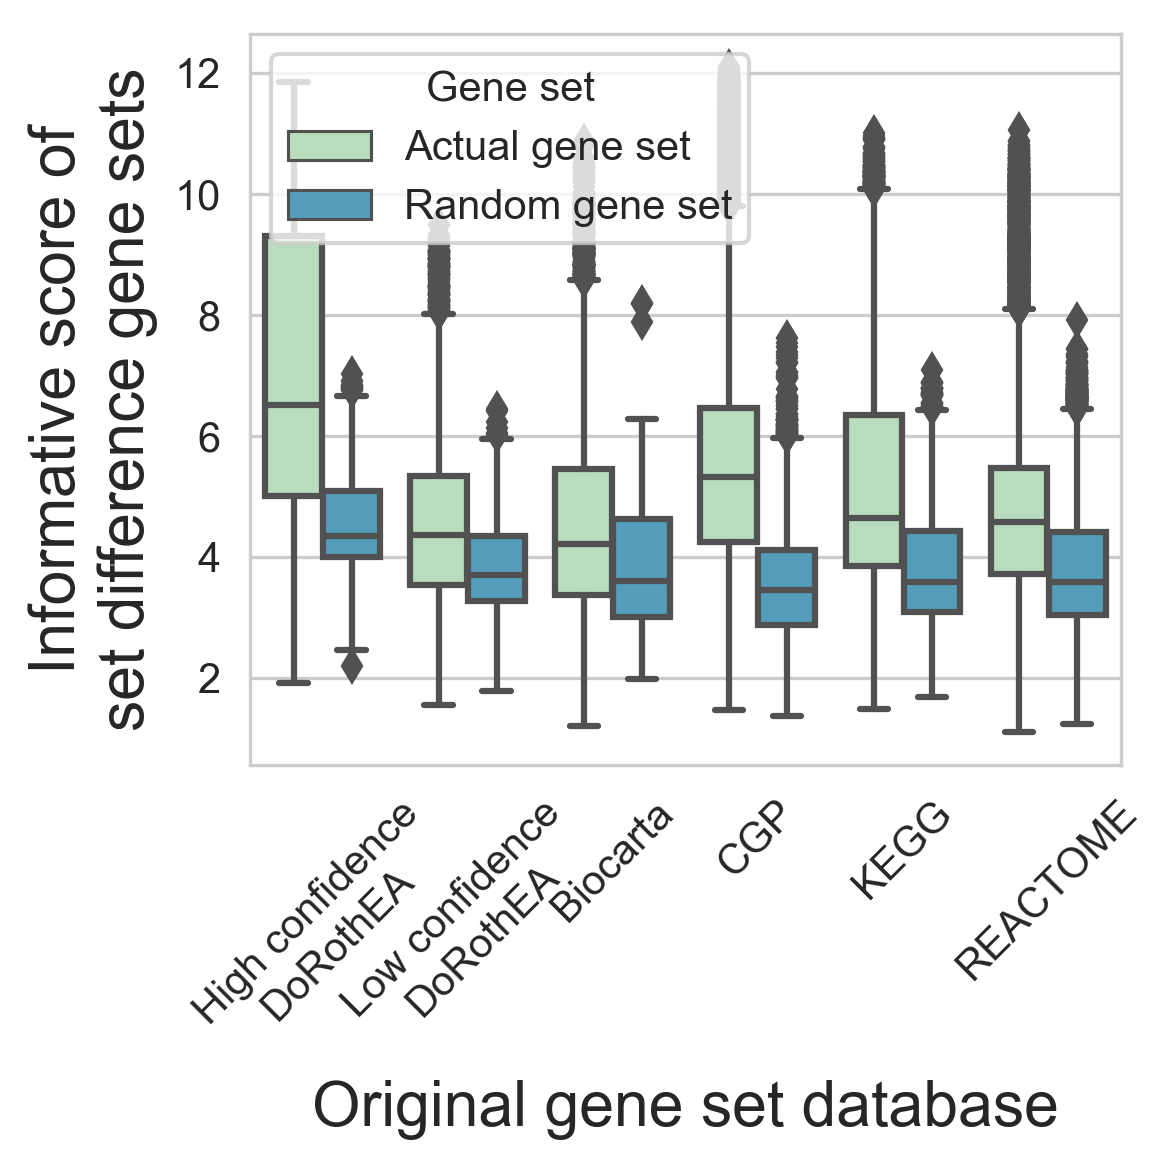

In [6]:
scores = plot_set_difference(bname='progeny', atype='_abs')
plt.savefig('../figures/raw/Fig5B.pdf')

In [72]:
model = smf.ols('Delta ~ Data', data=scores[scores['Random']==False]).fit()
model.params

Intercept                   6.930875
Data[T.BEST_dorothea_CD]   -2.423755
Data[T.BIOCARTA]           -2.381324
Data[T.CGP]                -1.349791
Data[T.KEGG]               -1.829337
Data[T.REACTOME]           -2.196602
dtype: float64

In [10]:
def infromative_score_decrease(bname='progeny', atype='_abs'):
    dnames=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','REACTOME','CGP','BIOCARTA']
    delta={}
    for dname1 in dnames:
        delta[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_filtered',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_filtered',dname1,'_filtered',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            delta[dname1]+=list(score_2minus1.values-score.values)
    delta_df=pd.DataFrame(columns=['Data','Delta'])
    for dname in delta:
        temp=pd.DataFrame(columns=delta_df.columns)
        temp['Delta']=delta[dname]
        temp['Data']=dname
        delta_df=pd.concat([delta_df,temp])
    delta_df['Random']='Actual gene set'    
    delta_random={}
    for dname1 in dnames:
        delta_random[dname1]=[]
        for dname2 in list(set(dnames)-set([dname1])):
            score=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname2,'_random_uniform_0',atype),
                          sep=',',header=0,index_col=0).abs().max(1)
            score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s%s_minus_%s%s%s.csv' % (bname,dname2,'_random_uniform_0',dname1,'_random_uniform_0',atype),
                                         sep=',',header=0,index_col=0).abs().max(1)
            if dname2<dname1:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[0]).values]
            else:
                score=score[pd.Series(score_2minus1.index).apply(lambda x:x.split('*')[1]).values]
            delta_random[dname1]+=list(score_2minus1.values-score.values)
    delta_random_df=pd.DataFrame(columns=['Data','Delta'])
    for dname in delta_random:
        temp=pd.DataFrame(columns=delta_random_df.columns)
        temp['Delta']=delta_random[dname]
        temp['Data']=dname
        delta_random_df=pd.concat([delta_random_df,temp])
    delta_random_df['Random']='Random gene set'
    delta = pd.concat([delta_df,delta_random_df])
    delta = delta.sort_values('Data')
    delta.columns = ['Data', 'Delta', 'Gene set']
    plt.figure(figsize=(4,4), dpi=300)
    sns.set_palette('GnBu',2)
    sns.barplot(delta['Data'],delta['Delta'], hue=delta['Gene set'])
    plt.xlabel('Removed gene set database', size=15)
    plt.xticks(range(6),['High confidence\nDoRothEA', 'Low confidence\nDoRothEA', 'Biocarta',
                            'CGP', 'KEGG' ,'REACTOME'],rotation=45)
    plt.ylabel('Informative score decrease', size=15)
    plt.tight_layout()
    plt.legend(loc=0, title='Gene set')
    return delta

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


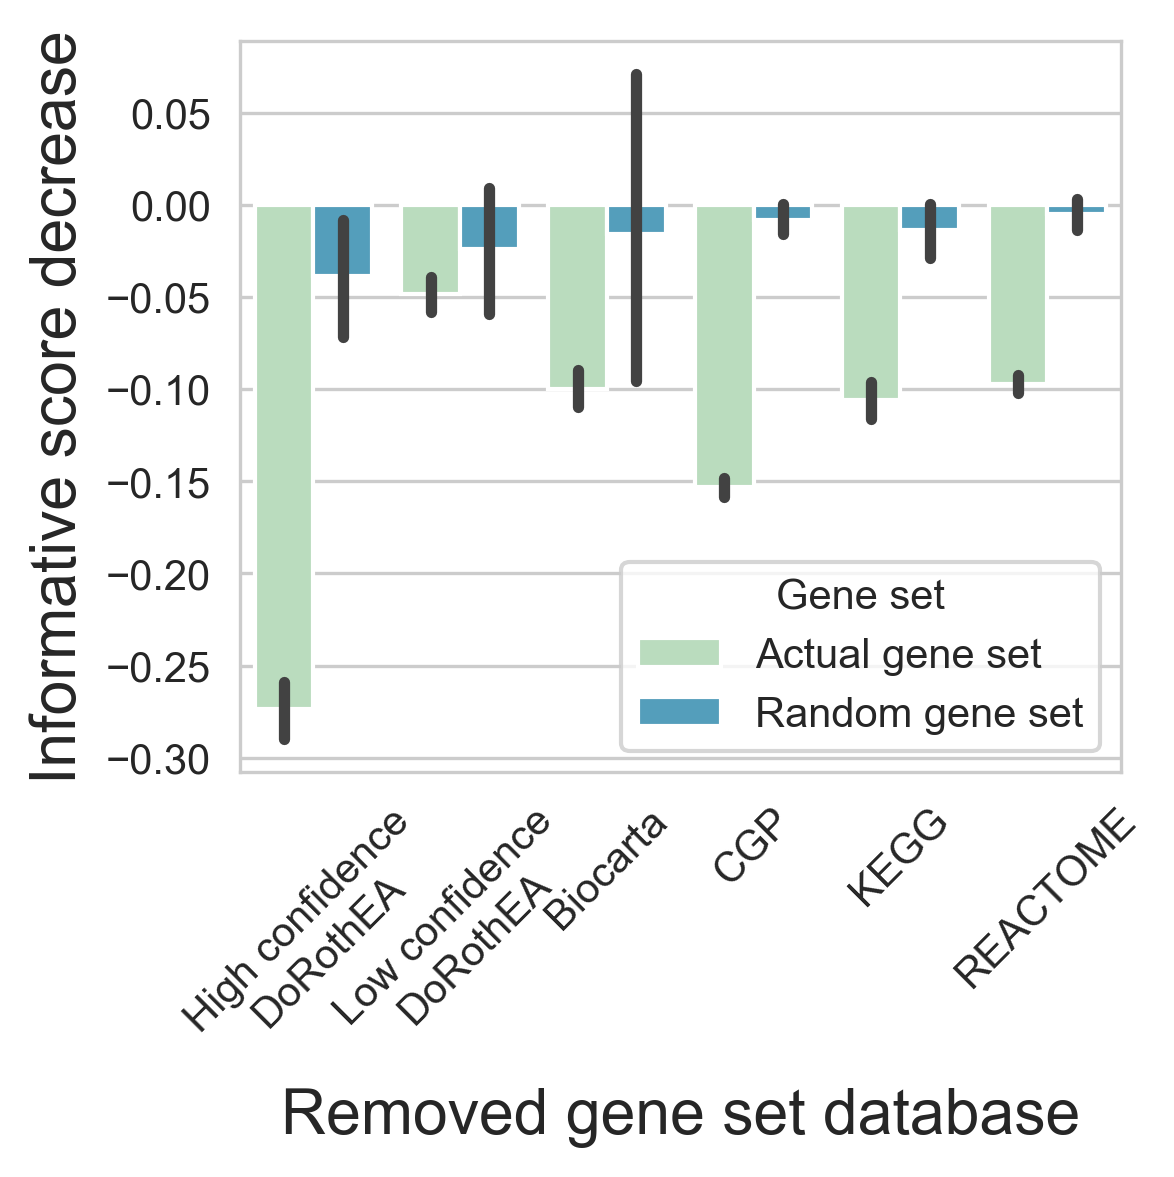

In [11]:
delta = infromative_score_decrease(bname='progeny', atype='_abs')
plt.savefig('../figures/raw/Fig5C.pdf')

In [76]:
model = smf.ols('Delta ~ Data', data=delta[delta['Random']==False]).fit()

In [78]:
model.params

Intercept                  -0.273290
Data[T.BEST_dorothea_CD]    0.225076
Data[T.BIOCARTA]            0.173529
Data[T.CGP]                 0.120168
Data[T.KEGG]                0.167289
Data[T.REACTOME]            0.176242
dtype: float64

In [79]:
 -0.273290 + 0.120168

-0.15312199999999998

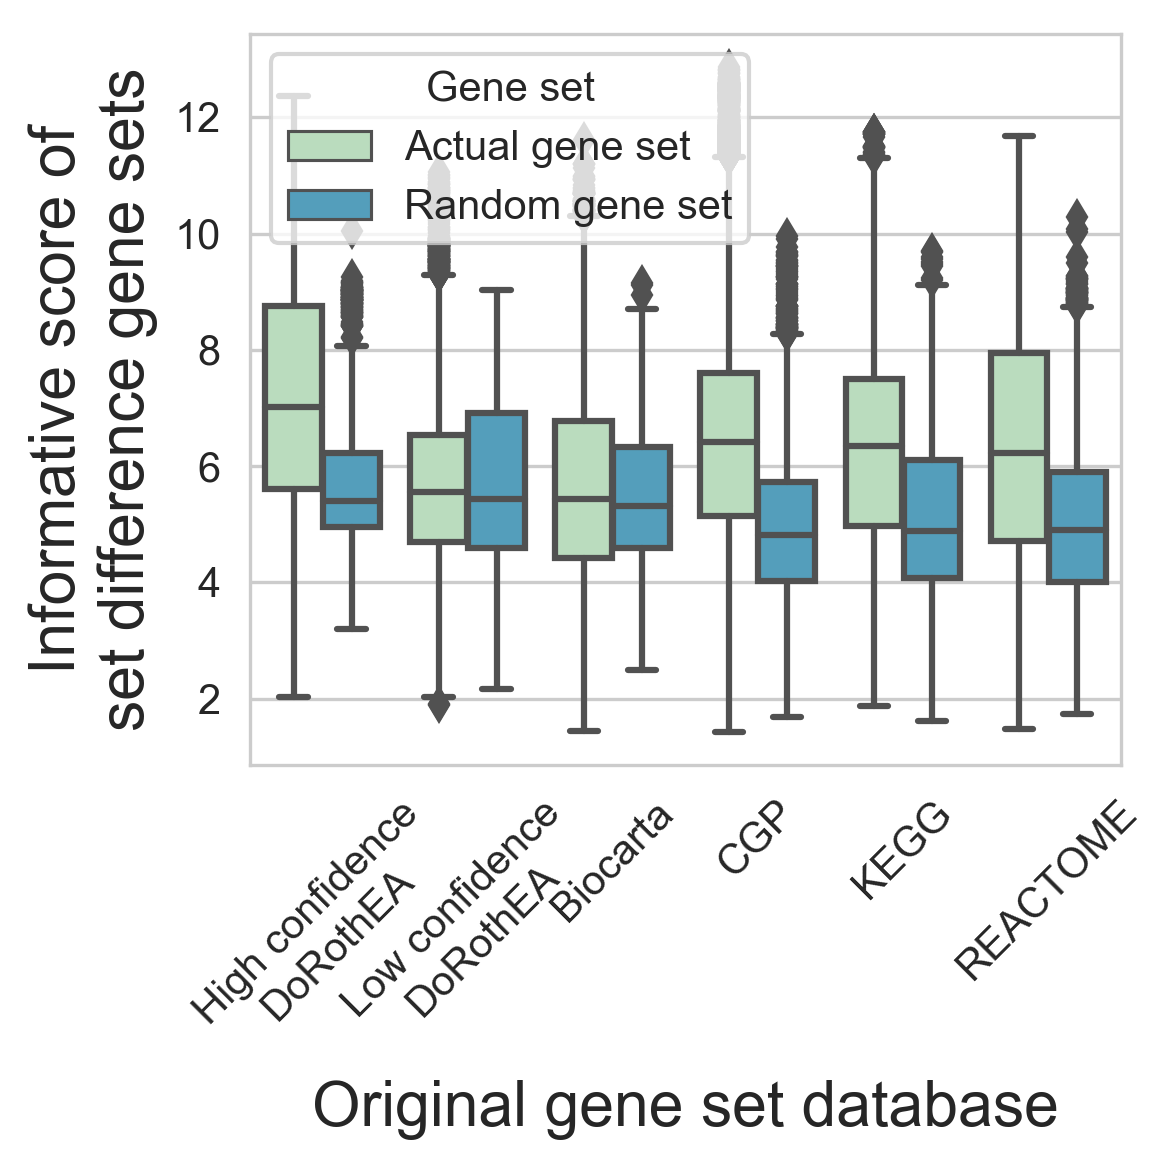

In [12]:
temp = plot_set_difference(bname='progeny', atype='')
plt.savefig('../figures/raw/SFig6A.pdf')

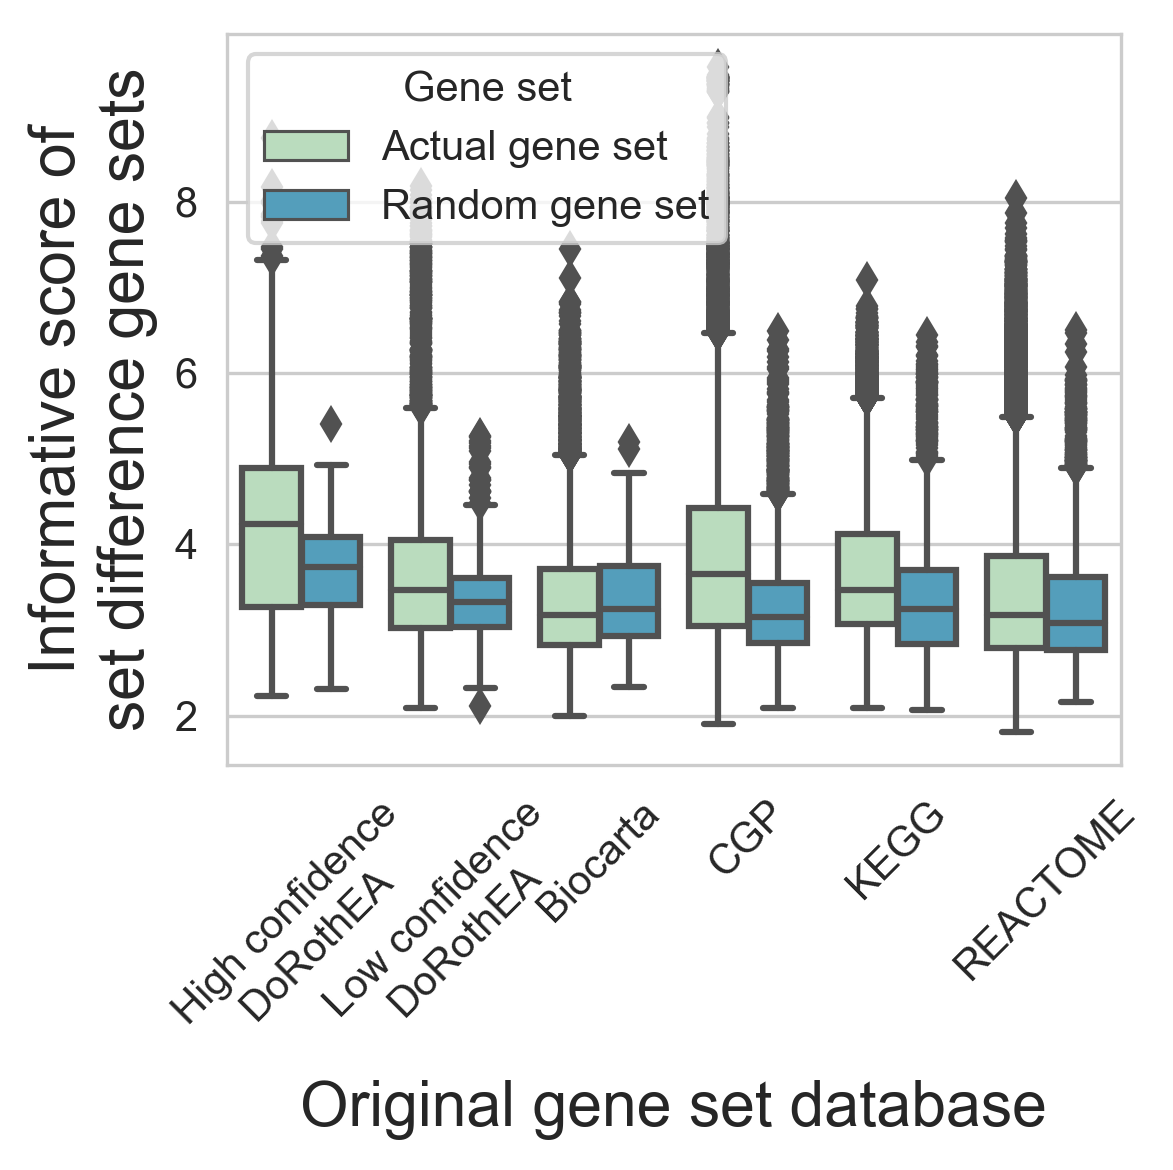

In [13]:
temp = plot_set_difference(bname='gdsc', atype='_abs')
plt.savefig('../figures/raw/SFig6B.pdf')

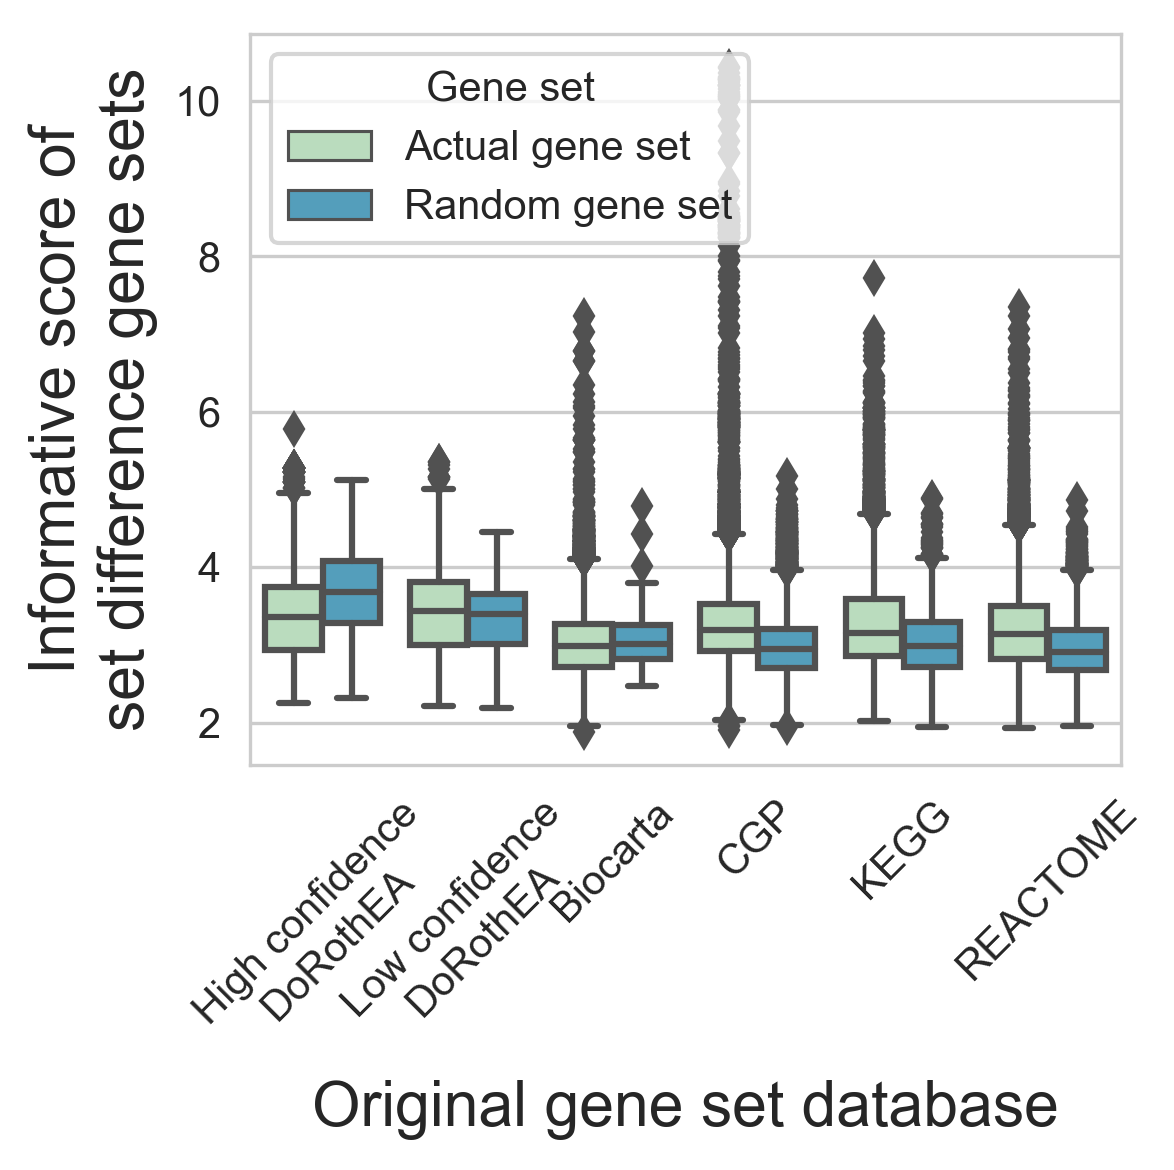

In [14]:
temp = plot_set_difference(bname='gdsc', atype='')
plt.savefig('../figures/raw/SFig6C.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


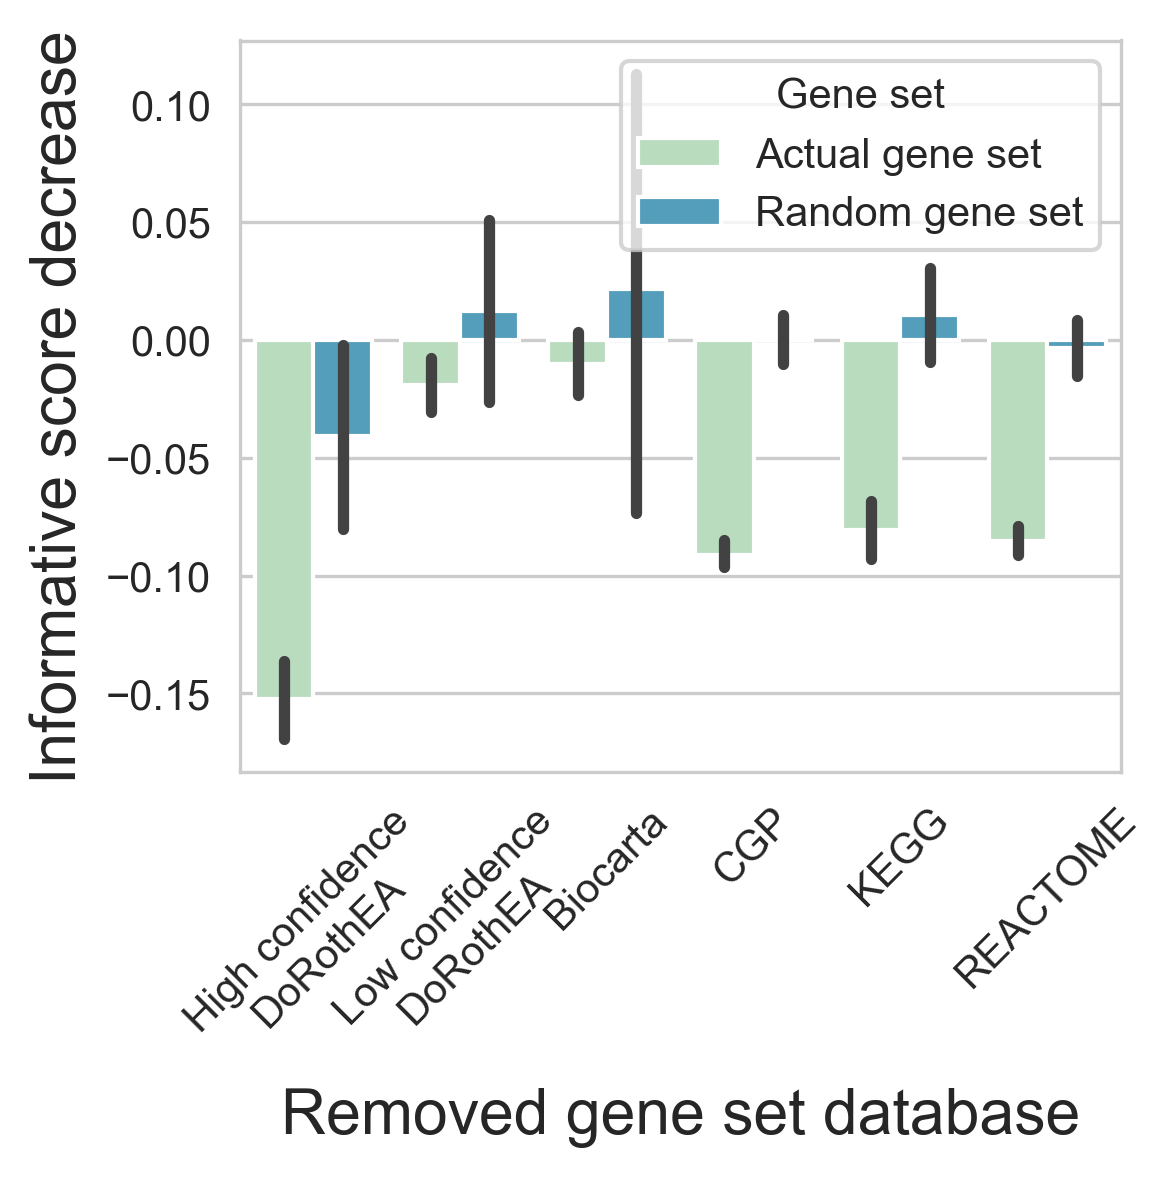

In [15]:
temp = infromative_score_decrease(bname='progeny', atype='')
plt.savefig('../figures/raw/SFig6D.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


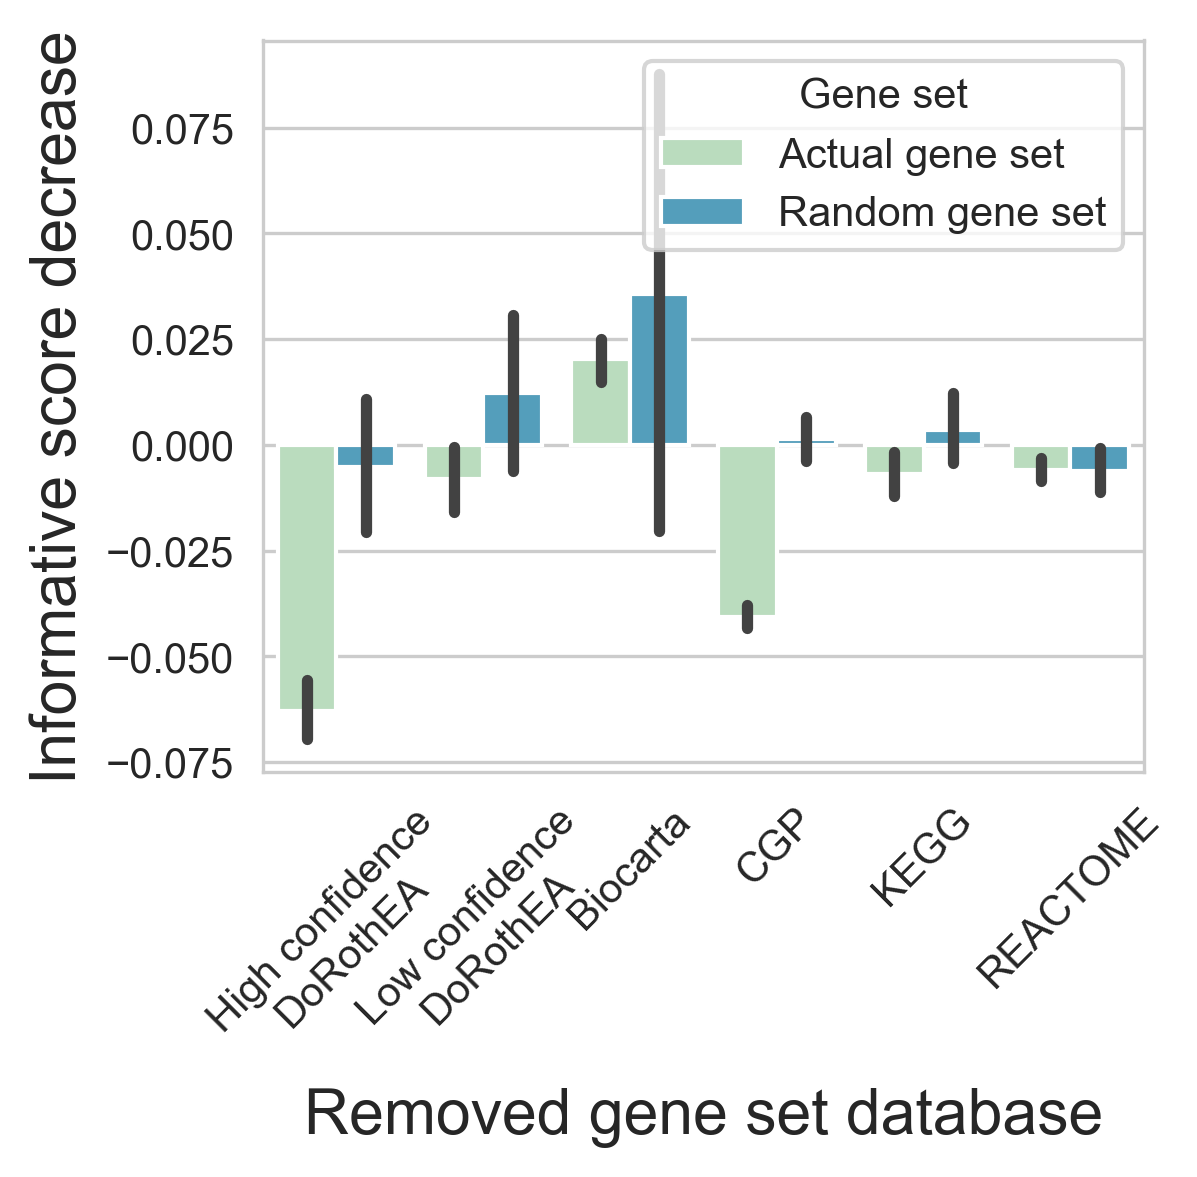

In [16]:
temp = infromative_score_decrease(bname='gdsc', atype='_abs')
plt.savefig('../figures/raw/SFig6E.pdf')

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


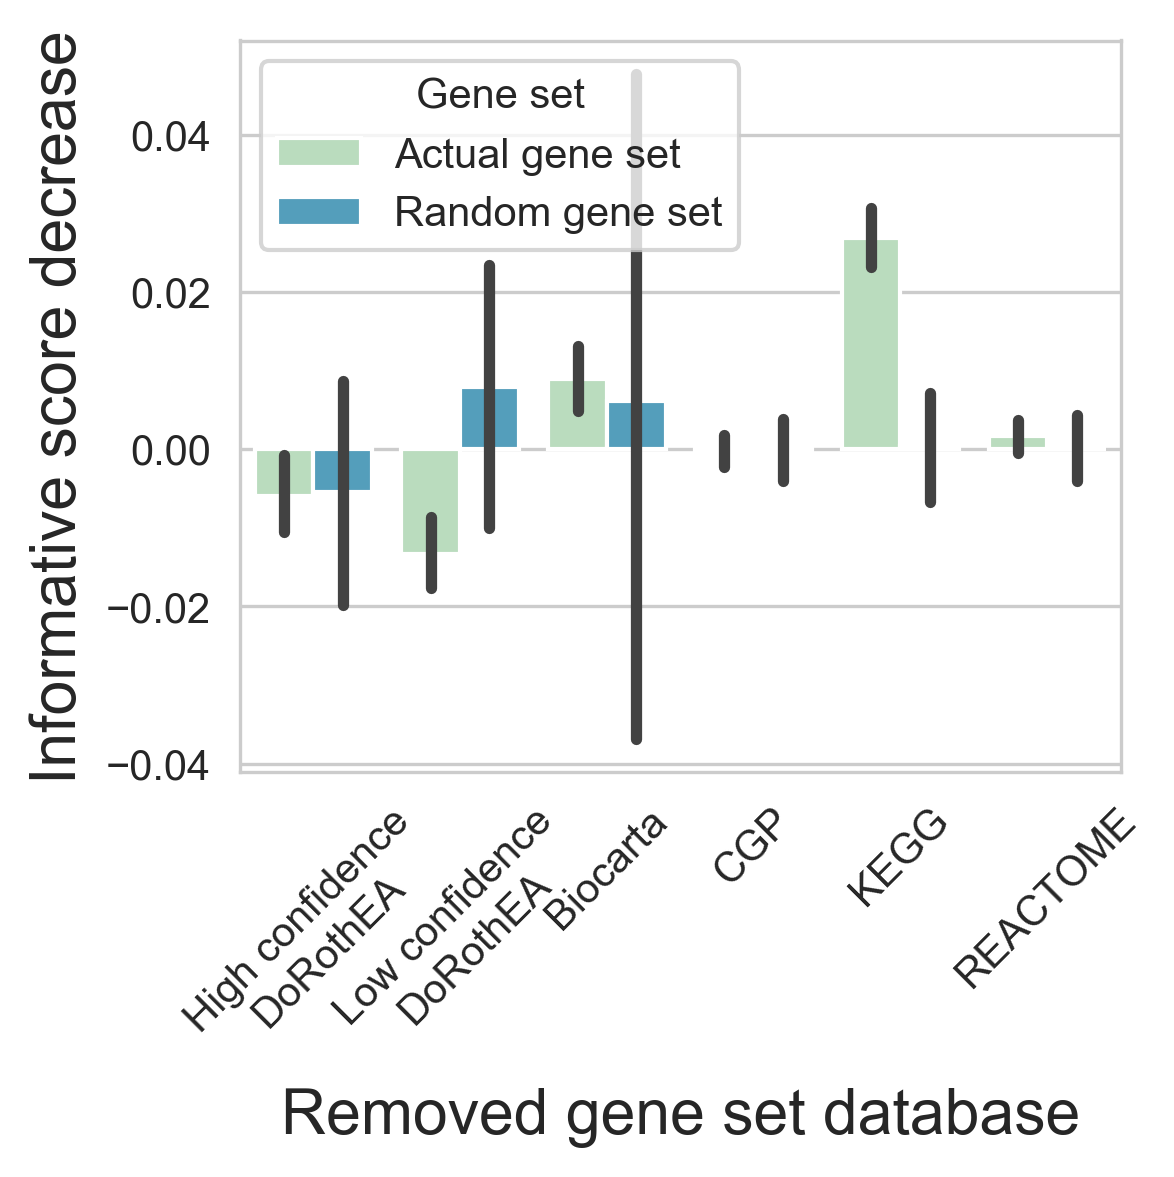

In [17]:
temp = infromative_score_decrease(bname='gdsc', atype='')
plt.savefig('../figures/raw/SFig6F.pdf')